In [86]:
# Key parameters
numFramesLookback = 64
numShiftedFrameSets = 16
numEpochs = 80
batchSize = 256

In [87]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, chi2

import plotly as ply
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib notebook

#os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow.keras import backend as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1L2



pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 80)

In [88]:
## Data Pre-Processing
#### We load in individual csv files collected from Rosbag on TurtleBot3 with ROS.

In [89]:
dataFolder = r"C:\Users\jaker\Documents\Experiment3Data-2019-11-21"

dataFiles = [
    r"gMitTile_s15_t8.csv",
    r"gMitTile_s15_t9.csv",
    r"gMitTile_s15_t10.csv",
    r"gTurf_s15_t3.csv",
    r"gTurf_s15_t4.csv",
    r"gTurf_s15_t5.csv",
    r"gTurf_s15_t6.csv",
    r"gTurf_s15_t7.csv",
    r"gTurf_s15_t8.csv",
    r"gTurf_s15_t9.csv",
    r"gTurf_s15_t10.csv",
    r"gArcTile_s15_t3.csv",
    r"gArcTile_s15_t4.csv",
    r"gArcTile_s15_t5.csv",
    r"gArcTile_s15_t6.csv",
    r"gArcTile_s15_t7.csv",
    r"gArcTile_s15_t8.csv",
    r"gArcTile_s15_t9.csv",
    r"gArcTile_s15_t10.csv",
    r"gCarp_s15_t3.csv",
    r"gCarp_s15_t4.csv",
    r"gCarp_s15_t5.csv",
    r"gCarp_s15_t6.csv",
    r"gCarp_s15_t7.csv",
    r"gCarp_s15_t8.csv",
    r"gCarp_s15_t9.csv",
    r"gCarp_s15_t10.csv",
    r"gMitTile_s15_t3.csv",
    r"gMitTile_s15_t4.csv",
    r"gMitTile_s15_t5.csv",
    r"gMitTile_s15_t6.csv",
    r"gMitTile_s15_t7.csv",
    "gMitTile_s15_t2.csv",
    "gTurf_s15_t1.csv",
    "gTurf_s15_t2.csv",
    "gArcTile_s15_t1.csv",
    "gArcTile_s15_t2.csv",
    "gCarp_s15_t1.csv",
    "gCarp_s15_t2.csv",
    "gMitTile_s15_t1.csv"
]

savePath = "Data-32Series-Delta30-Squared.csv"

In [90]:
""" 
For each data file we:
adjust the index, 
interpolate NaN values,
drop remaining NaN values, 
drop some empty columns.

We then augment the feature space with delta columns, 
and with polynomial columns,
and label the columns with terrain, speed, and trial number


"""

trials=[]

for i in range(len(dataFiles)):
    terrain = dataFiles[i].split('_')[0][1:]
    speed = dataFiles[i].split('_s')[1][:2]
    trial = dataFiles[i].split('_t')[1][0:2].strip('.')
    

    df = pd.read_csv(os.path.join(dataFolder, dataFiles[i]))
    df = df.rename(columns={'Unnamed: 0': 'Seq'})
    df = df.set_index('Seq')

    df = df.interpolate(method='polynomial', order=1)

    df = df.dropna()
    df = df.reset_index().drop(columns=['Seq'])

    df = df.drop(columns=['OdomPosZ', 'OdomOrientX', 'OdomOrientY', 'OdomLinY', 'OdomLinZ', 'OdomAngX', 'OdomAngY'])
    df['OdomPosXY'] = np.sqrt(df.OdomPosX**2 + df.OdomPosY**2)
    df = df.drop(columns=['OdomPosY', 'OdomPosX'])
    
    df = df.reset_index().drop(columns=['index'])
    df = df.drop(columns=['Sensor', 'Time'])
    
    origLength = df.shape[0]

    sampleSize = numFramesLookback # number of frames to look back at in RNN
    
    length = origLength - origLength%sampleSize
    df = df.iloc[:length]
    
    # we split into sections with overlap 
    numShifts = numShiftedFrameSets 
    
    shiftArrays = []
    for x in range(numShifts):
        shiftArrays.append(np.roll(df.to_numpy(), sampleSize//numShifts*x, axis=0))
    
    dfArray = np.concatenate(shiftArrays)
    
    numSamples = length//sampleSize*numShifts
    
    samples = np.array(np.array_split(dfArray, numSamples, axis=0))
    
    terrLabel = ['Carp', 'Turf', 'ArcTile', 'MitTile'].index(terrain)
    label = np.zeros(4)
    label[terrLabel] = 1.0
    labels = np.array([label for x in range(len(samples))])
    
    if i==0:
        xSamples = np.array(np.copy(samples))
        yLabels = np.array(np.copy(labels))
    else:
        xSamples = np.concatenate((xSamples, samples))
        yLabels = np.concatenate((yLabels, labels))
        
    trials = trials + [int(trial)]*samples.shape[0]
    
    print("From dataframe with length {} we added: ".format(origLength))                             
    print("Added {} samples of size {} by {} of class:".format(samples.shape[0], samples.shape[1],samples.shape[2]))
    print(label)
    


From dataframe with length 3831 we added: 
Added 944 samples of size 64 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 4331 we added: 
Added 1072 samples of size 64 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 4853 we added: 
Added 1200 samples of size 64 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 6101 we added: 
Added 1520 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5840 we added: 
Added 1456 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 3352 we added: 
Added 832 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5253 we added: 
Added 1312 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5251 we added: 
Added 1312 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 6668 we added: 
Added 1664 samples of size 64 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5075 we added: 
Added 1264 samples of size 64 by

In [91]:
xSamples = xSamples.astype('float64')
yLabels = yLabels.astype('float64')

In [92]:
yLabels.shape

(48688, 4)

In [93]:
xSamples.shape

(48688, 64, 15)

In [94]:
#X_train, X_test, Y_train, Y_test = train_test_split(xSamples, yLabels, test_size=0.2, shuffle=True)

In [95]:
X_train = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]<9 ])
Y_train = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]<9 ])

In [96]:
X_test = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]>=9 ])
Y_test = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]>=9 ])

In [97]:
X_test.shape

(11376, 64, 15)

In [98]:
verbose, epochs, batch_size = 1, numEpochs, batchSize
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [109]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features), bias_regularizer=L1L2(l1=0.1, l2=0.1)))
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu', bias_regularizer=L1L2(l1=0.1, l2=0.1)))
#model.add(Dropout(0.3))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               46400     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 404       
Total params: 56,904
Trainable params: 56,904
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=verbose)

Train on 37312 samples, validate on 11376 samples
Epoch 1/80
37312/37312 [==============================] - 6s 155us/sample - loss: 18.5053 - accuracy: 0.7537 - val_loss: 19.6891 - val_accuracy: 0.2983
Epoch 2/80
37312/37312 [==============================] - 3s 77us/sample - loss: 14.3838 - accuracy: 0.8914 - val_loss: 16.5485 - val_accuracy: 0.1246
Epoch 3/80
37312/37312 [==============================] - 3s 77us/sample - loss: 11.0575 - accuracy: 0.9302 - val_loss: 15.2849 - val_accuracy: 0.1702oss: 11.7
Epoch 4/80
37312/37312 [==============================] - 3s 77us/sample - loss: 8.2529 - accuracy: 0.9544 - val_loss: 12.4851 - val_accuracy: 0.2025
Epoch 5/80
37312/37312 [==============================] - 3s 79us/sample - loss: 5.9290 - accuracy: 0.9681 - val_loss: 11.0324 - val_accuracy: 0.2407
Epoch 6/80
37312/37312 [==============================] - 3s 79us/sample - loss: 4.0139 - accuracy: 0.9760 - val_loss: 9.8721 - val_accuracy: 0.2359
Epoch 7/80
37312/37312 [==============

37312/37312 [==============================] - 3s 90us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.2682 - val_accuracy: 0.5472
Epoch 56/80
37312/37312 [==============================] - 3s 89us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.3385 - val_accuracy: 0.5468
Epoch 57/80
37312/37312 [==============================] - 3s 90us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.4221 - val_accuracy: 0.5458
Epoch 58/80
37312/37312 [==============================] - 3s 91us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.4810 - val_accuracy: 0.5446
Epoch 59/80
37312/37312 [==============================] - 3s 87us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.5482 - val_accuracy: 0.5431
Epoch 60/80
37312/37312 [==============================] - 3s 87us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.5636 - val_accuracy: 0.5480
Epoch 61/80
37312/37312 [==============================] - 3s 87us/sample - loss: 0.0055 - accuracy: 1.0000 - va

In [111]:
_, accuracy =  model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)

In [112]:
accuracy

0.53146976

<IPython.core.display.Javascript object>


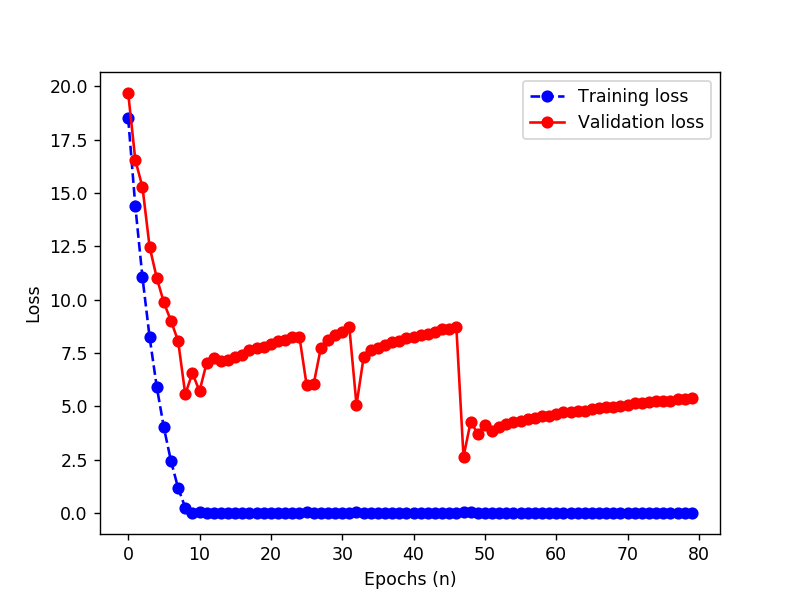

In [113]:
# graphical results
plt.figure()
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

<IPython.core.display.Javascript object>


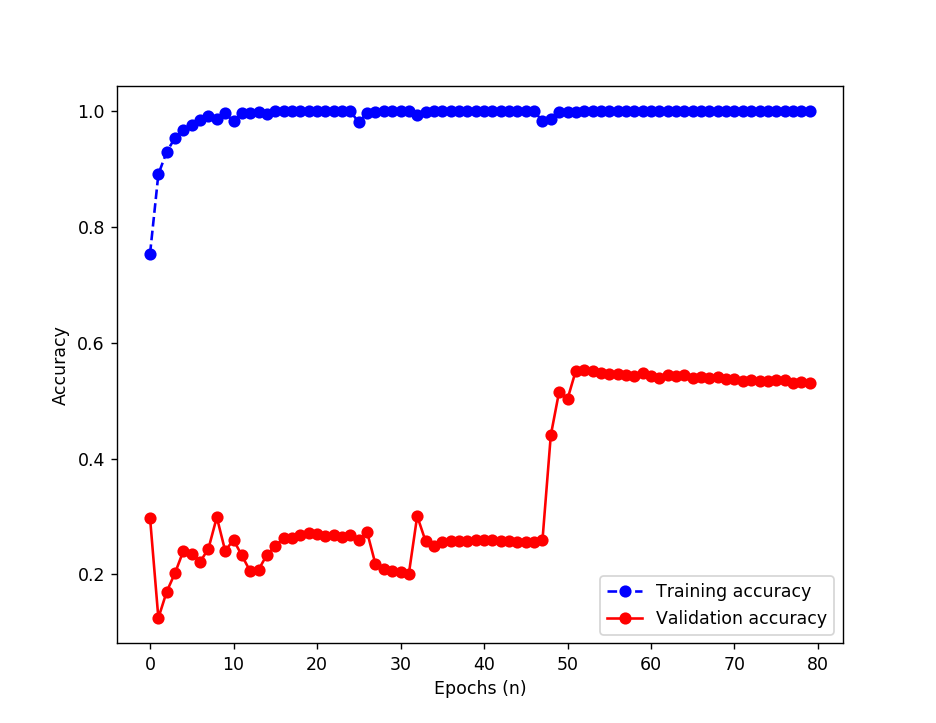

In [114]:
plt.figure()
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()